In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
%%html
<style>
table {margin-left: 0 !important;}
</style>

### Executive Summary
This analysis utilizes the public BigQuery San Francisco Bikeshare dataset, and seeks to answer two questions:<br>
1) What are the 5 most frequent 'commuter' trips<br>
2) An adjusted proposal for optimizing revenue based on the dataset<br>

In this analysis, we find that there are two customer types: subscribers and customers.  Subscribers and customers behave differently, with subscribers taking much shorter, but much more frequent trips on average, whereas customers take fewer trips, but spend more time riding on average when they do.

Because of this, we define commuter trips as those executed by subscribers between the hours of 5AM and 10AM, and being at least 10 minutes or longer (which is approximately the average time for a subscriber trip).  The trips that show up in this query with greatest frequency are our 5 most frequent commuter trips:

<table>
    <tr>
        <td><b>Number</b></td>
        <td><b>Start Station</b></td>
        <td><b>End Station</b></td>
        <td><b>Number Trips</b></td>
    </tr>
    <tr>
        <td>1</td>
        <td>San Francisco Caltrain(Townsend at 4th)</td>
        <td>Temporary Transbay Terminal (Howard at Beale)</td>
        <td>2777</td>
    </tr>
    <tr>
        <td>2</td>
        <td>San Francisco Caltrain(Townsend at 4th)</td>
        <td>Harry Bridges Plaza(Ferry Building)</td>
        <td>2540</td>
    </tr>
    <tr>
        <td>3</td>
        <td>San Francisco Caltrain 2 (330 Townsend)</td>
        <td>Market at 10th</td>
        <td>2445</td>
    </tr>
    <tr>
        <td>4</td>
        <td>San Francisco Caltrain(Townsend at 4th)</td>
        <td>Steuart at Market</td>
        <td>2170</td>
    </tr>
    <tr>
        <td>5</td>
        <td>San Francisco Caltrain(Townsend at 4th)</td>
        <td>Davis at Jackson</td>
        <td>2014</td>
    </tr>
</table>


In addition, we start our revenue analysis by setting up a control group (i.e. every trip charged a flat rate of 5 dollars) and then seek to come up with a modified revenue proposal that charges each customer segment more based on their greatest need.  For customers, this need is time, and the modified revenue scheme manifests itself with a flat rate of 5 dollars for the first hour, and 4 additional dollars after that, increaseing revenue from the control group of customers by approximately 44% based on the dataset as given.  

For subscribers, this need is the number of trips, and so we offer a package for unlimited monthly trips at a 5% premium to what the cost of purchasing each trip individually would be.  Some subscribers will choose to purchase each trip individually, but for those who have enough total trips over the course of a month to justify the monthly pass, this will increase revenue over the control group by between 0% and 10% depending on the rate of adoption.

### Process for identifying most frequent commuter trips
A) Query data to isolate only subscribers, trips that are 10 minutes or longer, and take place betwee 5AM and 10AM<br>
B) Identify the 5 most frequent starting points<br>
C) Within each starting point, identify the most frequent ending points<br>
D) The trips that have the largest number of start - end connections are our commuter trips

In [7]:
# querying data to identify most frequent starting points for commuters

! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(trip_id) AS count, start_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE TIME(start_date) <= TIME("2015-09-24 10:00:00 UTC") AND TIME(start_date) >= TIME("2015-09-24 05:00:00 UTC") AND subscriber_type = "Subscriber" AND duration_sec >= 600 GROUP BY start_station_name ORDER BY count DESC' > morning.csv;
morning = pd.read_csv('morning.csv')
morning.head(10)

Waiting on bqjob_r2d482768a5a4ae5_0000016650f4c333_1 ... (0s) Current status: DONE   

,count,start_station_name
0,25430,San Francisco Caltrain (Townsend at 4th)
1,16145,San Francisco Caltrain 2 (330 Townsend)
2,6461,Harry Bridges Plaza (Ferry Building)
3,6030,Temporary Transbay Terminal (Howard at Beale)
4,3931,South Van Ness at Market
5,3801,Grant Avenue at Columbus Avenue
6,3601,Steuart at Market
7,3277,Market at 10th
8,3168,Townsend at 7th
9,2976,2nd at Townsend


In [20]:
# Most frequent end stations for first starting station

! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(start_station_name) AS count, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE TIME(start_date) <= TIME("2015-09-24 10:00:00 UTC") AND TIME(start_date) >= TIME("2015-09-24 05:00:00 UTC") AND subscriber_type = "Subscriber" AND duration_sec >= 600 AND start_station_name = "San Francisco Caltrain (Townsend at 4th)" GROUP BY end_station_name ORDER BY count DESC' > start1.csv;
station_1 = pd.read_csv('start1.csv')
station_1.head(10)

Waiting on bqjob_r3b7335d1c9fa862a_000001664c62fd54_1 ... (0s) Current status: DONE   

,count,end_station_name
0,2777,Temporary Transbay Terminal (Howard at Beale)
1,2540,Harry Bridges Plaza (Ferry Building)
2,2170,Steuart at Market
3,2014,Davis at Jackson
4,1773,Embarcadero at Folsom
5,1553,Clay at Battery
6,1511,Beale at Market
7,1449,Embarcadero at Vallejo
8,1395,Market at 10th
9,1249,Market at Sansome


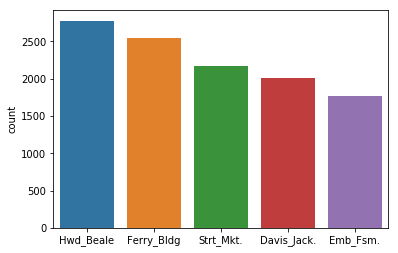

In [45]:
station_1_head = station_1.head(5)
chart_1 = sns.barplot(x=["Hwd_Beale", "Ferry_Bldg",
    "Strt_Mkt.", "Davis_Jack.", "Emb_Fsm."], y="count" , data=station_1_head)

In [21]:
# Most frequent end stations for second starting station

! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(start_station_name) AS count, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE TIME(start_date) <= TIME("2015-09-24 10:00:00 UTC") AND TIME(start_date) >= TIME("2015-09-24 05:00:00 UTC") AND subscriber_type = "Subscriber" AND duration_sec >= 600 AND start_station_name = "San Francisco Caltrain 2 (330 Townsend)" GROUP BY end_station_name ORDER BY count DESC' > start2.csv;
station_2 = pd.read_csv('start2.csv')
station_2.head(10)

Waiting on bqjob_r83b5eff57ed6d44_000001664c633be0_1 ... (0s) Current status: DONE   

,count,end_station_name
0,2445,Market at 10th
1,1365,Harry Bridges Plaza (Ferry Building)
2,1216,Steuart at Market
3,1181,Embarcadero at Folsom
4,1174,Temporary Transbay Terminal (Howard at Beale)
5,1075,Market at Sansome
6,876,Davis at Jackson
7,706,Broadway St at Battery St
8,684,Beale at Market
9,672,Mechanics Plaza (Market at Battery)


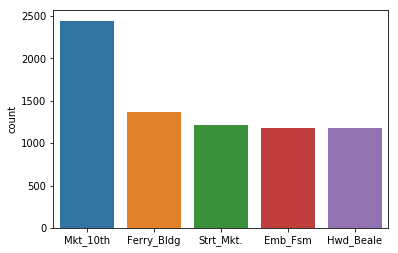

In [47]:
station_2_head = station_2.head(5)
chart_2 = sns.barplot(x=["Mkt_10th", "Ferry_Bldg",
    "Strt_Mkt.", "Emb_Fsm", "Hwd_Beale"], y="count" , data=station_2_head)

In [23]:
# Most frequent end stations for third starting station

! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(start_station_name) AS count, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE TIME(start_date) <= TIME("2015-09-24 10:00:00 UTC") AND TIME(start_date) >= TIME("2015-09-24 05:00:00 UTC") AND subscriber_type = "Subscriber" AND duration_sec >= 600 AND start_station_name = "Harry Bridges Plaza (Ferry Building)" GROUP BY end_station_name ORDER BY count DESC' > start3.csv;
station_3 = pd.read_csv('start3.csv')
station_3.head(10)

Waiting on bqjob_r581b6ec5d7752f9b_000001664c63a0d9_1 ... (0s) Current status: DONE   

,count,end_station_name
0,1535,San Francisco Caltrain (Townsend at 4th)
1,1308,Townsend at 7th
2,1076,2nd at Townsend
3,634,San Francisco Caltrain 2 (330 Townsend)
4,339,5th at Howard
5,328,Market at 10th
6,271,2nd at South Park
7,200,Yerba Buena Center of the Arts (3rd @ Howard)
8,106,2nd at Folsom
9,93,Embarcadero at Sansome


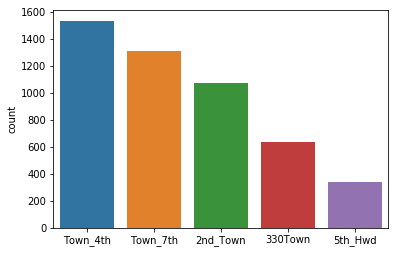

In [48]:
station_3_head = station_3.head(5)
chart_3 = sns.barplot(x=["Town_4th", "Town_7th",
    "2nd_Town", "330Town", "5th_Hwd"], y="count" , data=station_3_head)

In [24]:
# Most frequent end stations for fourth starting station

! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(start_station_name) AS count, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE TIME(start_date) <= TIME("2015-09-24 10:00:00 UTC") AND TIME(start_date) >= TIME("2015-09-24 05:00:00 UTC") AND subscriber_type = "Subscriber" AND duration_sec >= 600 AND start_station_name = "Temporary Transbay Terminal (Howard at Beale)" GROUP BY end_station_name ORDER BY count DESC' > start4.csv;
station_4 = pd.read_csv('start4.csv')
station_4.head(10)

Waiting on bqjob_r1fefcd62930720a_000001664c63e8eb_1 ... (0s) Current status: DONE   

,count,end_station_name
0,1382,Townsend at 7th
1,723,South Van Ness at Market
2,707,Market at 10th
3,648,Golden Gate at Polk
4,543,San Francisco Caltrain (Townsend at 4th)
5,344,Embarcadero at Sansome
6,285,Civic Center BART (7th at Market)
7,269,Grant Avenue at Columbus Avenue
8,192,San Francisco Caltrain 2 (330 Townsend)
9,157,Powell Street BART


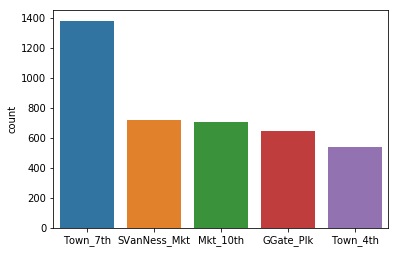

In [50]:
station_4_head = station_4.head(5)
chart_4 = sns.barplot(x=["Town_7th", "SVanNess_Mkt",
    "Mkt_10th", "GGate_Plk", "Town_4th"], y="count" , data=station_4_head)

In [26]:
# Most frequent end stations for fifth starting station

! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(start_station_name) AS count, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE TIME(start_date) <= TIME("2015-09-24 10:00:00 UTC") AND TIME(start_date) >= TIME("2015-09-24 05:00:00 UTC") AND subscriber_type = "Subscriber" AND duration_sec >= 600 AND start_station_name = "South Van Ness at Market" GROUP BY end_station_name ORDER BY count DESC' > start5.csv;
station_5 = pd.read_csv('start5.csv')
station_5.head(10)

Waiting on bqjob_r40518a00b098e03d_000001664c645953_1 ... (0s) Current status: DONE   

,count,end_station_name
0,493,Market at Sansome
1,332,Embarcadero at Sansome
2,306,San Francisco Caltrain (Townsend at 4th)
3,265,Mechanics Plaza (Market at Battery)
4,206,Spear at Folsom
5,197,Beale at Market
6,196,2nd at South Park
7,193,Post at Kearny
8,165,Howard at 2nd
9,154,Temporary Transbay Terminal (Howard at Beale)


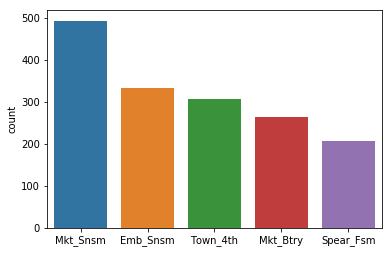

In [51]:
station_5_head = station_5.head(5)
chart_5 = sns.barplot(x=["Mkt_Snsm", "Emb_Snsm",
    "Town_4th", "Mkt_Btry", "Spear_Fsm"], y="count" , data=station_5_head)

In [1]:
%%html
<style>
table {margin-left: 0 !important;}
</style>

### Conclusion: Most Frequent Commuter Trips
<table>
    <tr>
        <td><b>Number</b></td>
        <td><b>Start Station</b></td>
        <td><b>End Station</b></td>
        <td><b>Number Trips</b></td>
    </tr>
    <tr>
        <td>1</td>
        <td>San Francisco Caltrain(Townsend at 4th)</td>
        <td>Temporary Transbay Terminal (Howard at Beale)</td>
        <td>2777</td>
    </tr>
    <tr>
        <td>2</td>
        <td>San Francisco Caltrain(Townsend at 4th)</td>
        <td>Harry Bridges Plaza(Ferry Building)</td>
        <td>2540</td>
    </tr>
    <tr>
        <td>3</td>
        <td>San Francisco Caltrain 2 (330 Townsend)</td>
        <td>Market at 10th</td>
        <td>2445</td>
    </tr>
    <tr>
        <td>4</td>
        <td>San Francisco Caltrain(Townsend at 4th)</td>
        <td>Steuart at Market</td>
        <td>2170</td>
    </tr>
    <tr>
        <td>5</td>
        <td>San Francisco Caltrain(Townsend at 4th)</td>
        <td>Davis at Jackson</td>
        <td>2014</td>
    </tr>
</table>


### Process for finding Optimal Pricing
We begin by estimating total revenue with a control pricing schema (flat rate of $5 for all trips).  The goal of estimating this control is to understand how much revenue we would reasonably expect to generate in the absence of an optimized pricing schema, and then identify dimensions along which pricing could be optimized.

In terms of pricing, you can adjust how you charge along three different dimensions:

A) Time - charge for the amount of time spent on the bike<br>
B) Trips - charge for the number of trips taken<br>
C) Binary Licence - charge for the privilege of using the service versus not<br>

In order to maximize revenue, it is logical to create a pricing scheme that charges customers the most for the services they use most.  (i.e. if you spend lots of time on the bike, charge per unit of time, if you take many short trips, charge per trip rather than per unit of time).<br> 

The following EDA will seek to delineate different types of buying behavior between customers and subscribers along the dimensions of time/trips/usage to figure out how to charge each to maximize revenue.

In [49]:
# control revenue calculation - our scheme should improve on this control
! bq query --use_legacy_sql=false --format=csv 'SELECT (COUNT(trip_id)*5) as control_revenue_in_USD FROM `bigquery-public-data.san_francisco.bikeshare_trips`' > control_revenue.csv;
control_revenue = pd.read_csv("control_revenue.csv")
control_revenue

Waiting on bqjob_r713d3238e0f7d6eb_0000016650100af6_1 ... (0s) Current status: DONE   

,control_revenue_in_USD
0,4918240


In [13]:
# find average duration of ride by subscriber
! bq query --use_legacy_sql=false --format=csv 'SELECT AVG(duration_Sec) AS avg_subscriber_ride_time, MIN(duration_sec) AS min_subscriber_ride_time, MAX(duration_sec) AS max_subscriber_ride_time FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type="Subscriber"' > subscriber_duration.csv;
subscriber_duration = pd.read_csv('subscriber_duration.csv')
subscriber_duration


Waiting on bqjob_r190b36acdeccb5bf_000001664f2c120a_1 ... (0s) Current status: DONE   

,avg_subscriber_ride_time,min_subscriber_ride_time,max_subscriber_ride_time
0,582.76424,60,1852590


In [11]:
# find number of trips ridden by subscribers
! bq query --use_legacy_sql=false --format=csv 'SELECT count(trip_id) AS subscriber_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type="Subscriber"' > subscriber_trips.csv;
subscriber_trips = pd.read_csv('subscriber_trips.csv')
subscriber_trips

Waiting on bqjob_r3dc44285027c186f_000001664f24caca_1 ... (0s) Current status: DONE   

,subscriber_trips
0,846839


In [14]:
# find average duration of ride by customer
! bq query --use_legacy_sql=false --format=csv 'SELECT AVG(duration_Sec) AS avg_customer_ride_time, MIN(duration_sec) AS min_customer_ride_time, MAX(duration_sec) AS max_customer_ride_time FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type="Customer"' > customer_duration.csv;
customer_duration = pd.read_csv('customer_duration.csv')
customer_duration

Waiting on bqjob_r5daae48b0a302041_000001664f2cf9a8_1 ... (0s) Current status: DONE   

,avg_customer_ride_time,min_customer_ride_time,max_customer_ride_time
0,3718.78516,60,17270400


In [8]:
# find number of trips ridden by customers
! bq query --use_legacy_sql=false --format=csv 'SELECT count(trip_id) AS customer_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type="Customer"' > customer_trips.csv;
customer_trips = pd.read_csv('customer_trips.csv')
customer_trips

Waiting on bqjob_r70fcfbd5cc16ab53_0000016650f74ad1_1 ... (0s) Current status: DONE   

,customer_trips
0,136809


### Intermediate Conclusion
It is clear that subscribers tend to spend less time on their bikes (~10 minutes on average) as they are most likely using the bike merely as a means of moving from one place to another

By contrast, customers spend a great deal of time on their bikes (~60 minutes on average) as they are most
likely using them for enjoyment and exploration

Therefore, we should charge the customers who spend the most time on their bikes based on the duration of their trip ,and subscribers based on the number of trips they take.

In [9]:
# find number customer trips greater than one hour
! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(duration_sec) AS one_hour FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE duration_sec >= 3600 AND subscriber_type="Customer"' > one_hour.csv;
one_hour = pd.read_csv("one_hour.csv")
one_hour

Waiting on bqjob_r9da441a2a23e2_0000016650f7da52_1 ... (0s) Current status: DONE   

,one_hour
0,25826


### Customer Revenue Pricing Conclusion
Looking at the data, it is clear that the vast majority of trips are under one hour (~80%) and that the average is highly skewed by a smaller number of trips that take much longer.  Our revenue strategy will be to charge extra for these trips.  Each customer trip of one hour or less will be charged a flat fee of 5 dollars, trips greater than 1 hour will be charged at a rate of 4 dollars per hour to ensure that you not only achieve more revenue for two hours than one, but customers are charged a lower rate to keep them incentivized to ride for longer

In [65]:
# establishing control revenue for just customer trips
! bq query --use_legacy_sql=false --format=csv 'SELECT (COUNT(trip_id)*5) AS customer_control_revenue FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type="Customer"' > customer_control_revenue.csv;
customer_control_revenue = pd.read_csv("customer_control_revenue.csv")
customer_control_revenue

Waiting on bqjob_r66f07207c818f182_00000166501ec501_1 ... (0s) Current status: DONE   

,customer_control_revenue
0,684045


In [11]:
# modified revenue for customer trips less than or equal to one hour
! bq query --use_legacy_sql=false --format=csv 'SELECT (COUNT(duration_sec)*5) AS customer_revenue_flat_fee FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE duration_sec <= 3600 AND subscriber_type="Customer"' > customer_revenue_flat_fee.csv;
customer_revenue_flat_fee = pd.read_csv("customer_revenue_flat_fee.csv")
customer_revenue_flat_fee

Waiting on bqjob_r1cfa026e7add8b67_0000016650fa5155_1 ... (0s) Current status: DONE   

,customer_revenue_flat_fee
0,554935


In [10]:
# modified revenue for customer trips greater than one hour
! bq query --use_legacy_sql=false --format=csv 'SELECT SUM((duration_sec/3600)*4) AS customer_revenue_per_hour FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE duration_sec > 3600 AND subscriber_type="Customer"' > customer_revenue_per_hour.csv;
customer_revenue_per_hour = pd.read_csv("customer_revenue_per_hour.csv")
customer_revenue_per_hour

Waiting on bqjob_r3ecc213598b2216c_0000016650fa1813_1 ... (0s) Current status: DONE   

,customer_revenue_per_hour
0,428087.542222


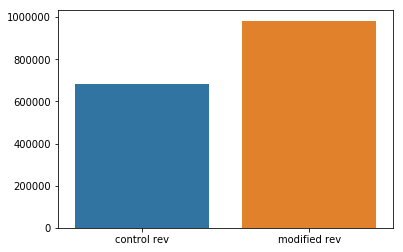

In [71]:
# comparing control customer revenue versus modified customer revenue
customer_revenue = sns.barplot(x=["control rev", "modified rev"], y=[684045, 983022])

### Subscriber Strategy
With subscribers, our approach to maximizing revenue is to charge as much per trip as possible.  If a subscriber were to pay the 5 dollar flat fee each time for a commute to and from work each day, that would equate to a monthly fee of 200 dollars, and a yearly fee of 2400 dollars.  We will offer a package that guarantees unlimited trips per month at a 10% premium discount to the cost of the flat monthly fee of 200 (i.e. 220)

In [2]:
# establishing control revenue for just customer trips
! bq query --use_legacy_sql=false --format=csv 'SELECT (COUNT(trip_id)*5) AS subscriber_control_revenue FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type="Subscriber"' > subscriber_control_revenue.csv;
subscriber_control_revenue = pd.read_csv("subscriber_control_revenue.csv")
subscriber_control_revenue

Waiting on bqjob_r46f07bebb6d60439_0000016650db5da8_1 ... (0s) Current status: DONE   

,subscriber_control_revenue
0,4234195


In [12]:
# establishing control revenue for just customer trips
! bq query --use_legacy_sql=false --format=csv 'SELECT (COUNT(trip_id)*5.5) AS subscriber_modified_revenue FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type="Subscriber"' > subscriber_modified_revenue.csv;
subscriber_modified_revenue = pd.read_csv("subscriber_modified_revenue.csv")
subscriber_modified_revenue

Waiting on bqjob_r556bcdf8fd960e65_0000016650fb1d6d_1 ... (0s) Current status: DONE   

,subscriber_modified_revenue
0,4657614.5


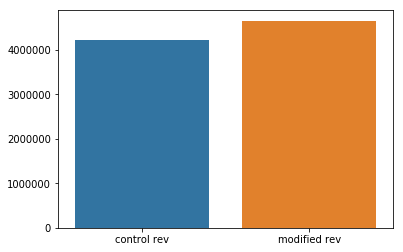

In [4]:
# comparing control subscriber revenue versus modified subscriber revenue
subscriber_revenue = sns.barplot(x=["control rev", "modified rev"], y=[4234195, 4657615])

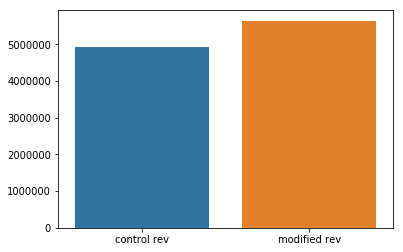

In [5]:
# comparing total control revenue versus total modified revenue
total_revenue = sns.barplot(x=["control rev", "modified rev"], y=[4918240, 5640637])